<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


# 1. Initialize

In [1]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'trained_models',
 'DataPreprocessing.ipynb',
 'checkpoints',
 'Heatmap_each.ipynb',
 'Update_leaf.ipynb']

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')


In [4]:
from utils.hourglass import *
from utils.dataloader import *
from utils.heatmap_utils import *

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim_tree = 5 # how deep the regression tree is 
num_tree = 3 # number of regression trees
variance_gaussian = 5

num_fc = int(num_tree*(2**(dim_tree-1)-1))
num_leaf_nodes = int(num_tree*2**(dim_tree-1))

# 2. Data Loader

In [ ]:
helen_trainset = Helen_set(dataset_type="train",var=variance_gaussian)

Loading [1/2000] pictures......


In [ ]:
helen_testset = Helen_set(dataset_type="test",var=variance_gaussian)

In [ ]:
train_dataloder = DataLoader(helen_trainset, batch_size=30)
test_dataloder = DataLoader(helen_testset, batch_size=30)

# 3. Pre Train

In [ ]:
helen_sampleset = Helen_set(dataset_type="sample")
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

In [ ]:
critical = torch.nn.MSELoss()

nIters = 200
HGNet = HGNet().to(device)
optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
loss_hist = torch.zeros(nIters)
loss_epoch = torch.zeros(10)

for iter in range(nIters):
  for i, (x,_,y) in enumerate(sample_dataloder):
    x = Variable(x,requires_grad=True).float().to(device)
    y = Variable(y).float().to(device)
    y_pred = HGNet.forward(x)
    loss = critical(y_pred, y)
    loss_epoch[i] = loss.item()

    if i == 9:
      loss_avg = torch.sum(loss_epoch)/10
      loss_hist[iter] = loss_avg
      if (iter+1)%10 == 0 or iter == 0:
        print('Iter [%d/%d] loss %.4f' %(iter+1, nIters, loss_avg))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
plt.title("Training Loss")

In [ ]:
# torch.save(HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt")

# 4. Tune Training

## 4.1 Sample Set

In [6]:
helen_sampleset = Helen_set(dataset_type="sample",var=variance_gaussian)
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)
helen_sampletest = Helen_set(dataset_type="sample_test",var=variance_gaussian)
sample_test_dataloder = DataLoader(helen_sampletest, batch_size=10)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......
Loading [1/30] pictures......


## 4.2 Network

In [7]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

<All keys matched successfully>

In [8]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

## 4.3 Training

In [9]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 1000

criterion_MSE = torch.nn.MSELoss()
criterion_KL = torch.nn.KLDivLoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 60

### Training using L2 Loss

In [ ]:
# Using L2 Loss

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))
  
  #####################################
  ### Train Hourglass
  ### eyes: [36:48]
  #####################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12,256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)
      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,256,256)

      # get mask for computing cnn loss
      cnn_mask = get_mask(cnn_heatmaps,threshold=0.5)
      loss = criterion_MSE(cnn_heatmaps*cnn_mask, y[:,36:48,:,:]*cnn_mask)
      loss_epoch += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  
    if (iter+1)%20 == 0 or iter == 0:
      print('     CNN training, Iter [%d/%d], loss_L2: %.8f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))

  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))


  #####################################
  ### Train Regression Trees using pinv
  #####################################
  with torch.no_grad():
    leaf_q_new = torch.zeros(num_leaf_nodes,12,256*256).to(device)
    loss0 = 0

    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

      leaf_q_this = torch.matmul(torch.linalg.pinv(cnn_prob), y_expand) #(8,12*256*256)
      leaf_q_new += leaf_q_this.reshape(num_leaf_nodes,12,-1)

      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q_this.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

      
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    
    # Sharpen Leaf_q
    # for nleaf in range(num_leaf_nodes):
    #   for npoints in range(12):
    #     leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    # leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    # leaf_q = leaf_q.reshape(num_leaf_nodes,-1)

    print("     RF training, coordinate loss: %.4f" %(loss0/10))

  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_L2_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round)+'.pt'))
  torch.save(leaf_q, os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_L2_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round)+'.pt'))

  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_L2_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_L2_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))



### Training using Log likelihood

In [ ]:
a = torch.zeros(2,3)

############################################################################
Round [1/10], Using GPU
     CNN training, Iter [1/30], loss_KL: 4.6369685
     -----> CNN training time: ## 3.24 mins ## 


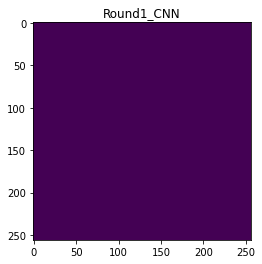

     RF training, Batch 1, rf_iter [1/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [15/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [30/60], loss_KL: 4.6377
     RF training, Batch 1, rf_iter [45/60], loss_KL: 4.6377
     RF training, Batch 1, rf_iter [60/60], loss_KL: 4.6377
     RF training, Batch 4, rf_iter [1/60], loss_KL: 4.6375
     RF training, Batch 4, rf_iter [15/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [30/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [45/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [60/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [1/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [15/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [30/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [45/60], loss_KL: 4.6377
     RF training, Batch 8, rf_iter [60/60], loss_KL: 4.6377
     RF training, coordinate loss: 5758.7891


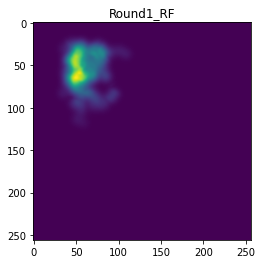

     -----> RF training time: ## 8.79 mins ## 
     -----> Training time for this round: ## 12.03 mins ## 
############################################################################
Round [2/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 4.6372122
     CNN training, Iter [50/1000], loss_KL: 4.6372120
     CNN training, Iter [100/1000], loss_KL: 4.6372119
     CNN training, Iter [150/1000], loss_KL: 4.6372119
     CNN training, Iter [200/1000], loss_KL: 4.6372116
     CNN training, Iter [250/1000], loss_KL: 4.6372115
     CNN training, Iter [300/1000], loss_KL: 4.6372113
     CNN training, Iter [350/1000], loss_KL: 4.6372111
     CNN training, Iter [400/1000], loss_KL: 4.6372109
     CNN training, Iter [450/1000], loss_KL: 4.6372107
     CNN training, Iter [500/1000], loss_KL: 4.6372107
     CNN training, Iter [550/1000], loss_KL: 4.6372105
     CNN training, Iter [600/1000], loss_KL: 4.6372103
     CNN training, Iter [650/1000], loss_KL: 4.6372101
     CNN training, Iter [

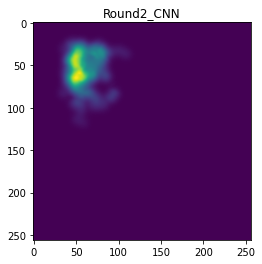

     RF training, Batch 1, rf_iter [1/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [15/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [30/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [45/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [60/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [1/60], loss_KL: 4.6375
     RF training, Batch 4, rf_iter [15/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [30/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [45/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [60/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [1/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [15/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [30/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [45/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [60/60], loss_KL: 4.6376
     RF training, coordinate loss: 6048.6304


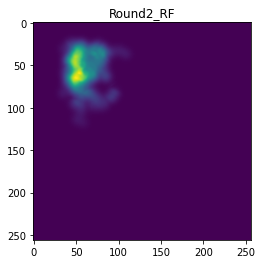

     -----> RF training time: ## 8.70 mins ## 
     -----> Training time for this round: ## 115.70 mins ## 
############################################################################
Round [3/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 4.6372103
     CNN training, Iter [50/1000], loss_KL: 4.6372102
     CNN training, Iter [100/1000], loss_KL: 4.6372101
     CNN training, Iter [150/1000], loss_KL: 4.6372099
     CNN training, Iter [200/1000], loss_KL: 4.6372097
     CNN training, Iter [250/1000], loss_KL: 4.6372096
     CNN training, Iter [300/1000], loss_KL: 4.6372094
     CNN training, Iter [350/1000], loss_KL: 4.6372093
     CNN training, Iter [400/1000], loss_KL: 4.6372092
     CNN training, Iter [450/1000], loss_KL: 4.6372089
     CNN training, Iter [500/1000], loss_KL: 4.6372089
     CNN training, Iter [550/1000], loss_KL: 4.6372087
     CNN training, Iter [600/1000], loss_KL: 4.6372086
     CNN training, Iter [650/1000], loss_KL: 4.6372084
     CNN training, Iter 

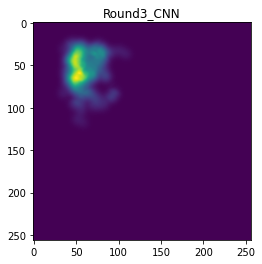

     RF training, Batch 1, rf_iter [1/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [15/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [30/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [45/60], loss_KL: 4.6376
     RF training, Batch 1, rf_iter [60/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [1/60], loss_KL: 4.6375
     RF training, Batch 4, rf_iter [15/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [30/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [45/60], loss_KL: 4.6376
     RF training, Batch 4, rf_iter [60/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [1/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [15/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [30/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [45/60], loss_KL: 4.6376
     RF training, Batch 8, rf_iter [60/60], loss_KL: 4.6376
     RF training, coordinate loss: 6311.0317


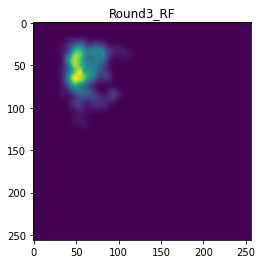

     -----> RF training time: ## 8.72 mins ## 
     -----> Training time for this round: ## 113.84 mins ## 
############################################################################
Round [4/10], Using GPU
     CNN training, Iter [1/1000], loss_KL: 4.6372080
     CNN training, Iter [50/1000], loss_KL: 4.6372079
     CNN training, Iter [100/1000], loss_KL: 4.6372076
     CNN training, Iter [150/1000], loss_KL: 4.6372075
     CNN training, Iter [200/1000], loss_KL: 4.6372073
     CNN training, Iter [250/1000], loss_KL: 4.6372073
     CNN training, Iter [300/1000], loss_KL: 4.6372071
     CNN training, Iter [350/1000], loss_KL: 4.6372071
     CNN training, Iter [400/1000], loss_KL: 4.6372070
     CNN training, Iter [450/1000], loss_KL: 4.6372069
     CNN training, Iter [500/1000], loss_KL: 4.6372069
     CNN training, Iter [550/1000], loss_KL: 4.6372067
     CNN training, Iter [600/1000], loss_KL: 4.6372065
     CNN training, Iter [650/1000], loss_KL: 4.6372064
     CNN training, Iter 

KeyboardInterrupt: ignored

In [10]:
# update using log likelihood

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))

  
  ######################################################
  ### Train Hourglass
  ### eyes: [36:48]
  ######################################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12,256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs, num_leaf_nodes, dim_tree, num_tree)

      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
      cnn_heatmaps = cnn_heatmaps/torch.sum(cnn_heatmaps,axis=1,keepdims=True)
      label_heatmaps = y[:,36:48,:,:].reshape(B*12,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)

      loss = -criterion_KL(cnn_heatmaps,label_heatmaps)
      loss_epoch += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if (iter+1)%50 == 0 or iter == 0:
      print('     CNN training, Iter [%d/%d], loss_KL: %.7f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))


  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))

  plt.imshow(cnn_heatmaps[0,:].reshape(256,256).detach().cpu())
  plt.title("Round"+str(round+1)+"_CNN")
  plt.savefig(os.path.join("checkpoints/RF_Avg/var_"+str(variance_gaussian),"Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN.png"))
  plt.show()


  ######################################################
  ### Train Regression Trees using variational bounding
  ######################################################
  with torch.no_grad():
    loss0 = 0

    leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    next_leaf_q = torch.zeros(leaf_q.shape).to(device)

    for i, (x,coord,y) in enumerate(sample_dataloder):
      new_leaf_q = leaf_q.clone()
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,12,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs, num_leaf_nodes, dim_tree, num_tree)

  
      for rf_iter in range(rf_Iters):
        for points_id in range(12):
          new_leaf_q[:,points_id,:] = update_iter(new_leaf_q[:,points_id,:], cnn_prob, y_expand[:,points_id,:])
        if ((i+1)%4 == 0 or i == 0) and ((rf_iter+1)%15 == 0 or rf_iter == 0):
          rf_loss_CE = loss_ce(B, new_leaf_q, cnn_prob, y_expand, num_leaf_nodes)
          print("     RF training, Batch %d, rf_iter [%d/%d], loss_KL: %.4f" %(i+1, rf_iter+1, rf_Iters, rf_loss_CE*224*224))
      next_leaf_q += new_leaf_q

      pred_coord0 = find_coord(torch.matmul(cnn_prob,new_leaf_q.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

    # normalize
    leaf_q = next_leaf_q/torch.sum(next_leaf_q,axis=2,keepdims=True)

    # Sharpen Leaf_q
    # leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    # for nleaf in range(num_leaf_nodes):
    #   for npoints in range(12):
    #     leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    # leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    # leaf_q = leaf_q.reshape(num_leaf_nodes,-1)


    print("     RF training, coordinate loss: %.4f" %(loss0/10))

  rf_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  plt.imshow(rf_heatmaps[0,:].reshape(256,256).detach().cpu())
  plt.title("Round"+str(round+1)+"_RF")
  plt.savefig(os.path.join("checkpoints/RF_Avg/var_"+str(variance_gaussian),"Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF.png"))
  plt.show()

  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/RF_Avg/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))
  torch.save(leaf_q, os.path.join("checkpoints/RF_Avg/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))

  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/RF_Avg/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/RF_Avg/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

## 4.4 Test

### Restore from saved weights

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round1.pt")))
leaf_q = torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round1.pt"))

In [ ]:
import torchsummary
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
torchsummary.summary(Tune_HGNet, (3,256,256))
print('parameters_count:',count_parameters(Tune_HGNet))

### Test

In [ ]:
heatmap_loss, coord_loss = 0, 0
Tune_HGNet.eval()
criterion = torch.nn.MSELoss()

for i, (img,coord,hm) in enumerate(sample_test_dataloder):
  img = img.float().to(device)
  img.requires_grad = True
  coord = coord.float().to(device)
  hm = hm.float().to(device)
  B = img.shape[0]
  
  outputs = Tune_HGNet.forward(img)
  cnn_prob = phi(outputs, num_leaf_nodes, dim_tree, num_tree)
  pred_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)) #(15,12*256*256)
  pred_coords = find_coord(pred_heatmaps) #(15,12*2)

  heatmap_loss += criterion(pred_heatmaps, hm[:,36:48,:,:].reshape(B,-1))
  coord_loss += torch.sum(torch.abs(pred_coords-coord[:,36:48,:].reshape(B,-1)))

print("Heatmap loss %.8f, Coord loss %.4f" %(heatmap_loss/10, coord_loss/10))

In [ ]:
phi(outputs, num_leaf_nodes, dim_tree, num_tree)[0:5,:]

In [ ]:
for ith in range(8):
  x = pred_coords[ith,::2].detach().cpu()
  y = pred_coords[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction %d" %ith)

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)

In [ ]:
ith = 0

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 1

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 2

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 3

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 4

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 5

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 6

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 7

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
plot_heatmaps = pred_heatmaps.reshape(B,12,256,256).detach().cpu()
plot_heatmaps_all = torch.sum(plot_heatmaps,axis=1)
plt.imshow(plot_heatmaps_all[ith,:,:])

In [ ]:
# one point
plt.imshow(plot_heatmaps[ith,0,:,:])

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[0,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[1,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[2,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[3,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[4,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[5,0,:,:].detach().cpu())

In [ ]:
image = torch.sum(hm, axis=1).detach().cpu()
plt.imshow(image[ith,:,:])

In [ ]:
plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())